# Realization and evaluation of SVRG algorithm on pattern recognition problems




## 1 Logistic Regression
To discover the performance of SVRG in convex optimization, compared to that of fixed-learning-rate SGD’s, L2-
regrularized logistic regression with cross-entropy loss is
performed. The regularization parameter is λ = 0.0001, and
the total number of gradient operations for both algorithms
is fixed to 10000. We used the same training dataset as John-
son and Zhang’s (Johnson & Zhang, 2013). Data is retrieved
from Python package tensorflow.examples.tutorials.mnist
in version 1.14.0 and directly used in analysis with no pre-
processing procedures.

### 1.1 Define functions

In [ ]:
#import packages
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow as tf
import tf_helpers as helpers
import time
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable, grad
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import copy
torch.manual_seed(0)

#resolve issue between torch and matplotlib
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
#define helper functions
def softmax(z):
   return np.array([(np.exp(el)/np.sum(np.exp(el))) for el in z])

def cost(W,F,L, reg):
   m = F.shape[0]
   mul = np.dot(F, W)
   sm_mul_T = softmax(mul)
   return -(1/m) * np.sum(L * np.log(sm_mul_T)) + reg/2/m*np.linalg.norm(W)

def gradient(W,F,L, reg):
   m = F.shape[0]  # get number of rows
   mul = np.dot(F, W)
   sm_mul_T = softmax(mul)
   return -(1 / m) * np.dot(F.T , (L - sm_mul_T)) + reg*W

In [ ]:
#define stochastic gradient descent algorithn and stochastic variance reduced gradient
def sgd(eta, reg = 0.0001, max_iter = 100000):
    W = np.zeros((785, 10)) #784 features + 1 basis
    ls = np.zeros(max_iter)
    us = np.zeros(max_iter)
    ts = np.zeros(max_iter)
    for i in range(max_iter):
        F, L = mnist.train.next_batch(200)
        F = np.insert(F,0, values=1, axis=1)

        #calculate trainng loss(whole not batch)
        F_val, L_val = mnist.train.next_batch(100)
        F_val = np.insert(F_val,0, values=1, axis=1)
        ls[i] = cost(W, F_val, L_val, reg)
        start = time.time()
        #calculate gradient and update
        gradients = gradient(W,F,L, reg)
        us[i] = np.sum(eta*gradients)
        W = W - (eta * (gradients))
        ts[i] = time.time() - start
        
        if i%10000 == 0:
            print(i/10000)
    
    return ls, W, us, ts

def svrg(eta, reg = 0.0001, max_iter = 100, m = 100):
    #initialize
    W = np.zeros((785, 10))
    ls = np.zeros(max_iter)
    us = np.zeros(max_iter*m)
    ts = np.zeros(max_iter)
    
    #train
    for s in range(max_iter):
        trainx_whole = np.insert(mnist.train.images,0, values=1, axis=1)
        trainy_whole = mnist.train.labels
        start = time.time()
        mu = gradient(W, trainx_whole, trainy_whole, reg)
        W_tloop = W
        for t in range(m):
            F, L = mnist.train.next_batch(100)
            F = np.insert(F,0, values=1, axis=1)
            updates = eta*(gradient(W_tloop, F, L, reg) -
                           gradient(W, F, L, reg) + mu)
            us[(s-1)*m + (t-1)] = np.sum(updates)
            W_tloop = W_tloop - updates
        W = W_tloop
        ts[s] = time.time() - start
        ls[s] = cost(W, trainx_whole, trainy_whole, reg)
        
        if s%10 == 0:
            print(s)

    return ls, W, us, ts

### 1.2 Train Models

In [ ]:
#import mnist dataset
mnist = input_data.read_data_sets("./datasets/MNIST_data/", one_hot=True)

Extracting ./datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


#### 1.2.1 Train SGD Model

In [ ]:
ls_005, wfinal_005, us_005, ts_005 = sgd(0.005, max_iter = 10000)
print("005 done")
ls_0025, wfinal_0025, us_0025, ts_0025 = sgd(0.0025, max_iter = 10000)
print("0025 done")
ls_001, wfinal_001, us_001, ts_001 = sgd(0.001, max_iter = 10000)
print("001 done")

0.0
005 done
0.0
0025 done
0.0
001 done


#### 1.2.2 Train SVRG Model

In [ ]:
ls_svrg, wfinal_svrg, us_svrg, ts_svrg = svrg(0.025)

#optimal weight approximation using large number of iterations
ls_long, wfinal_long, us_long, ts_long = svrg(0.0025, max_iter = 500)
plt.plot(ls_long)

### 1.3 Summary for Logstic Regression
We plot the cross-entropy training loss against gradient numbers. In order to observe the trend of training loss better, we only plot the training loss once every 100 gradient operations to prevent the plot from becoming too dense. For SGD algorithms with different learning rates, the convergence speed is negatively correlated to the learning rate, so the decreasing speed of training loss is slower for SGD with smaller learning rate. However, after approximately 6000 iterations, we no longer see significant difference between the training loss for SGD algorithms with different learning rates since all training loss oscillate between the interval $[0.25, 0.75]$. This confirms the disadvantage of fix-learning-rate SGD algorithms where convergency ends up towards a fix-size stochastic ball (Gower et al., 2020). 

On the other hand, convergence rate of SVRG algorithm exceeds that of all SGD’s, even when the learning rate of SVRG is greater than the leaning rates of SGDs. In addition, the training loss curve for SVRG is smooth, indicating that the training loss continues decreasing with almost no oscillation as iterations increases, which is useful when we need approximation with particularly low training loss. When compared with the original results from Johnson and Zhang  (Johnson & Zhang, 2013), the behavior of training loss is similar; however, the training loss in original results is lower, which we suspect may be due to different initialization strategies and different pre-processing procedures.

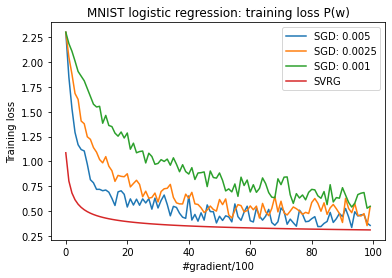

In [ ]:
#compare training loss
plt.plot(ls_005[::100], label = "SGD: 0.005")
plt.plot(ls_0025[::100], label = "SGD: 0.0025")
plt.plot(ls_001[::100], label = "SGD: 0.001")
plt.plot(ls_svrg, label = "SVRG")
plt.legend()
plt.title("MNIST logistic regression: training loss P(w)")
plt.xlabel('#gradient/100')
plt.ylabel("Training loss")
plt.show()

We plot the logarithm of training loss residual against gradient numbers for both SGD with learning rate of 0.001 and SVRG with learning rate of 0.025. Note that we compute the optimal gradient by running 1000 iterations in SVRG algorithm, in other words, the number of gradient update operations is 50000. Due to the limitation in computation power of our devices, the estimated optimal weight $w^*$ is fairly close to the weight estimates, especially for the weight estimates after approximately 6000 iterations. Such proximity is then amplified by the logarithm operation, causing large fluctuations in the right-half of the figure, thus causing the training loss residuals for large gradient numbers to become unreliable. 

If we focus on the training loss residuals for small gradient numbers, we will observe that the logarithm of training loss residual roughly forms a straight line, indicating that the training loss residual for both SGD and SVRG decreases exponentially. In addition, since the slope of the line for SVRG is slightly steeper than that if SGD, we assert that SVRG converges faster than SGD. The results in this graph is similar to that of Johnson, R. and Zhang, T’s

C:\Users\yuhon\anaconda3\envs\hello-tf\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


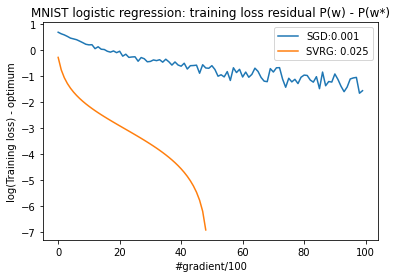

In [ ]:
#calculate P(w*)
train_x = np.insert(mnist.train.images, 0, values=1, axis=1)
p_star = cost(wfinal_long, train_x, mnist.train.labels, 0.0001)
residuals_001 = ls_001 - p_star

p_star_svrg = cost(wfinal_svrg, train_x, mnist.train.labels, 0.0001)
residuals_svrg = ls_svrg - p_star

#compare training loss residual P(w) - P(w*)
plt.plot(np.log(residuals_001[::100]), label = "SGD:0.001")
plt.plot(np.log(residuals_svrg), label = "SVRG: 0.025")
plt.legend()
plt.title("MNIST logistic regression: training loss residual P(w) - P(w*)")
plt.xlabel('#gradient/100')
plt.ylabel("log(Training loss) - optimum")
plt.show()

We use a step diagram to demonstrate the time
consumption of gradient update operations for different
algorithms. For demonstration purpose, each step increase
represents the time consumption of 100 gradient update
operations. We observe that each gradients update operation
for SVRG algorithm roughly takes twice as long as SGD’s,
which is reasonable since we need to calculate two different
gradient values when calculating the gradient approximation
in one SVRG iteration. Combine the result in this plot with
the result in Figure.1, we can confirm that there is a trade-
off between convergence speed and computation time per
iteration (Johnson & Zhang, 2013).

C:\Users\yuhon\anaconda3\envs\hello-tf\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\yuhon\anaconda3\envs\hello-tf\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 65289 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\yuhon\anaconda3\envs\hello-tf\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\yuhon\anaconda3\envs\hello-tf\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 65289 missing from current font.
  font.set_text(s, 0, flags=flags)


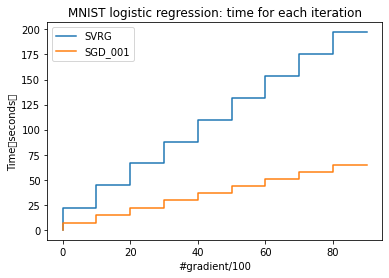

In [ ]:
#modify svrg sum
x_svrg = np.arange(100)
tsum_svrg = np.zeros(100)
for i in range(100-1):
    tsum_svrg[i+1] = tsum_svrg[i] + ts_svrg[i]
    
#modify sgd001 sum
x_001 = np.arange(10000)
tsum_001 = np.zeros(10000)
for i in range(10000-1):
    tsum_001[i+1] = tsum_001[i] + ts_001[i]

#compare time
plt.step(x_svrg[::10], tsum_svrg[::10], label = "SVRG")
plt.step(x_svrg[::10], tsum_001[::1000], label = "SGD_001")
plt.legend()
plt.title("MNIST logistic regression: time for each iteration")
plt.xlabel('#gradient/100')
plt.ylabel("Time（seconds）")
plt.show()

## 2 Convolutional Neural Network
To evaluate the performance of SVRG in nonconvex opti-
mization, compared to that of fixed-learning-rate SGD’s, we
used the PyTorch classes from GitHub repository (Fatras,
2018) to conduct neural network analysis with two convo-
lution layers. The regularization parameter is λ = 0.01,
and the total number of gradient calculation operations
for both algorithms is fixed to 25000. We used the same
training dataset CIFAR as Johnson and Zhang’s (Johnson
& Zhang, 2013). Data is retrieved from Python package
torchvision.datasets and used in analysis after normaliza-
tion.

### 2.1 Define functions

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        """
        Function to predict data's classification
        args : neural net, data
        output : prediction
        """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def partial_grad(self, data, target, loss_function):
        """
        Function to compute the grad
        args : data, target, loss_function
        return loss
        """
        outputs = self.forward(data)
        loss = loss_function(outputs, target)
        loss.backward() #compute grad
        return loss
    
    def calculate_loss_grad(self, dataset, loss_function, n_samples):
        """
        Function to compute the full loss and the full gradient
        args : dataset, loss function and number of samples
        return : total loss and full grad norm
        """
        total_loss = 0.0
        full_grad = 0.0
        for i_grad, data_grad in enumerate(dataset):
            inputs, labels = data_grad
            inputs, labels = Variable(inputs), Variable(labels) #wrap data and target into variable
            total_loss += (1./n_samples) * self.partial_grad(inputs, labels, loss_function).data
        
        for para in self.parameters():
            full_grad += para.grad.data.norm(2)**2
        
        return total_loss, (1./n_samples) * np.sqrt(full_grad)
    
    def svrg_backward(self, dataset, loss_function, n_epoch, learning_rate):
        """
        Function to updated weights with a SVRG backpropagation
        args : dataset, loss function, number of epochs, learning rate
        return : total_loss_epoch, grad_norm_epoch
        """
        ls = []
        total_loss_epoch = [0 for i in range(n_epoch)]
        grad_norm_epoch = [0 for i in range(n_epoch)]
        for epoch in range(n_epoch):
            running_loss = 0.0
            previous_net_sgd = copy.deepcopy(self) #update previous_net_sgd
            previous_net_grad = copy.deepcopy(self) #update previous_net_grad

            #Compute full grad
            previous_net_grad.zero_grad() # grad = 0
            total_loss_epoch[epoch], grad_norm_epoch[epoch] = previous_net_grad.calculate_loss_grad(dataset, loss_function, n_samples)
            print(total_loss_epoch[epoch], grad_norm_epoch[epoch])
            #Run over the dataset
            for i_data, data in enumerate(dataset):
                inputs, labels = data
                inputs, labels = Variable(inputs), Variable(labels) #wrap data and target into variable
                
                #Compute prev stoc grad
                previous_net_sgd.zero_grad() #grad = 0
                prev_loss = previous_net_sgd.partial_grad(inputs, labels, loss_function)
                
                #Compute cur stoc grad
                self.zero_grad() #grad = 0
                cur_loss = self.partial_grad(inputs, labels, loss_function)
                
                #Backward
                for param1, param2, param3 in zip(self.parameters(), previous_net_sgd.parameters(), previous_net_grad.parameters()): 
                    param1.data -= (learning_rate) * (param1.grad.data - param2.grad.data + (1./n_samples) * param3.grad.data)

                # print statistics
                running_loss += cur_loss.data
                
                if i_data % 1000 == 999:    # print every 2500 mini-batches
                    ls.append(running_loss/1000)
                    print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i_data + 1, running_loss / 1000))
                    running_loss = 0.0
                
        return total_loss_epoch, grad_norm_epoch, ls


In [ ]:
class sgdNet(nn.Module):
    def __init__(self):
        super(sgdNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 2.2 Train Model

In [ ]:
#load data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='C:/Users/yuhon/Documents/2022 winter/stad80/project/data_set', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='C:/Users/yuhon/Documents/2022 winter/stad80/project/data_set', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


#### 2.2.1 Train SDG model (using default optimizer)

In [ ]:
gradloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=False)

net = sgdNet()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
num_epoch = 5
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

start = time.time()
ls = []

for epoch in range(num_epoch):
    #compute full gradient and full loss function
    running_loss = 0.0
    net.zero_grad()
    for i, data in enumerate(gradloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = net(inputs)
        loss_grad = criterion(outputs, labels)
        loss_grad.backward()

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        net.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        for f in net.parameters():
            f.data.sub_(f.grad.data * learning_rate)

        # print statistics
        running_loss += loss.data
        ls.append(loss.data)
        if i % 2500 == 2499:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2500))
            running_loss = 0.0

end = time.time()
print('time is : ', end - start)
print('Finished Training')

[1,  2500] loss: 2.126
[1,  5000] loss: 1.797
[1,  7500] loss: 1.632
[1, 10000] loss: 1.527
[1, 12500] loss: 1.495
[2,  2500] loss: 1.397
[2,  5000] loss: 1.369
[2,  7500] loss: 1.333
[2, 10000] loss: 1.312
[2, 12500] loss: 1.294
[3,  2500] loss: 1.203
[3,  5000] loss: 1.198
[3,  7500] loss: 1.190
[3, 10000] loss: 1.185
[3, 12500] loss: 1.173
[4,  2500] loss: 1.076
[4,  5000] loss: 1.080
[4,  7500] loss: 1.094
[4, 10000] loss: 1.117
[4, 12500] loss: 1.101
[5,  2500] loss: 1.008
[5,  5000] loss: 1.034
[5,  7500] loss: 1.026
[5, 10000] loss: 1.011
[5, 12500] loss: 1.028
time is :  841.3146357536316
Finished Training


#### 2.2.2 Train SVRG model

In [ ]:
net = Net()
criterion = nn.CrossEntropyLoss()
n_epoch = 5
learning_rate = 0.01
start = time.time()
n_samples = len(trainloader)
print(n_samples)
total_loss_epoch, grad_norm_epoch, ls_svrg = net.svrg_backward(trainloader, criterion, n_epoch, learning_rate)

end = time.time()
print('time is : ', end - start)
print('Finished Training')

12500
tensor(2.3050) tensor(0.0389)
[1,  1000] loss: 2.296
[1,  2000] loss: 2.109
[1,  3000] loss: 1.880
[1,  4000] loss: 1.776
[1,  5000] loss: 1.699
[1,  6000] loss: 1.648
[1,  7000] loss: 1.590
[1,  8000] loss: 1.584
[1,  9000] loss: 1.526
[1, 10000] loss: 1.517
[1, 11000] loss: 1.493
[1, 12000] loss: 1.470
tensor(1.3842) tensor(0.9345)
[2,  1000] loss: 1.349
[2,  2000] loss: 1.302
[2,  3000] loss: 1.280
[2,  4000] loss: 1.257
[2,  5000] loss: 1.279
[2,  6000] loss: 1.267
[2,  7000] loss: 1.231
[2,  8000] loss: 1.202
[2,  9000] loss: 1.216
[2, 10000] loss: 1.182
[2, 11000] loss: 1.175
[2, 12000] loss: 1.217
tensor(1.2390) tensor(2.3389)
[3,  1000] loss: 1.140
[3,  2000] loss: 1.133
[3,  3000] loss: 1.154
[3,  4000] loss: 1.118
[3,  5000] loss: 1.112
[3,  6000] loss: 1.128
[3,  7000] loss: 1.106
[3,  8000] loss: 1.139
[3,  9000] loss: 1.073
[3, 10000] loss: 1.112
[3, 11000] loss: 1.112
[3, 12000] loss: 1.097
tensor(1.0508) tensor(1.1377)
[4,  1000] loss: 0.995
[4,  2000] loss: 1.038


### 2.3 Summary for Neural Network
We plot the cross-entropy loss training loss
against every 1000 iterations. We observe that after 25000
iterations, the weight approximations of SGD and SVRG is
similar, however the training loss curve of SGD algorithm
experiences large oscillations, while the training loss curve
of SGD algorithm remains smooth. This confirms the fact
that the gradient approximation of SVRG algorithm has smaller variance when being compared to SGD algorithm.

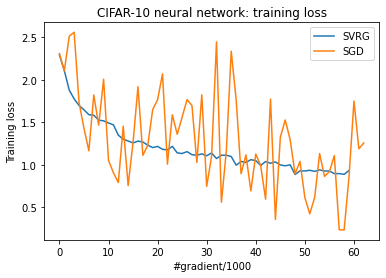

In [ ]:
#format ls from tensor to numeric
ls_num = np.zeros(len(ls_svrg))
for i in range(len(ls_svrg)):
    ls_num[i] = ls_svrg[i].numpy()

#comapre training loss
plt.plot(ls_num, label = "SVRG")
plt.plot(ls[::1000], label = "SGD")
plt.legend()
plt.title("CIFAR-10 neural network: training loss")
plt.xlabel('#gradient/1000')
plt.ylabel("Training loss")
plt.show()